In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold

from scipy.interpolate import griddata
from utilities import chirality, half_time, sample_contour_plot, predictions_df, hanging_line
import matplotlib
from matplotlib import cm
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings("ignore")

### This dataset has the data collected on the (100), (110), (111) samples with the GCN features pre-calculated

In [2]:
# Load Data
df_full = pd.read_csv('experimental_data_with_gcn_features.csv')
#Adjust display options
pd.set_option('display.max_columns', 100)
#Display Data
df_full.head(10)

,normal_miller_index,x_coordinate(mm),y_coordinate(mm),molecule,h,k,l,surface_chirality,halftime(s),stereographic_projection_x,stereographic_projection_y,GCN Density 4.75,GCN Density 4.833,GCN Density 4.917,GCN Density 5.0,GCN Density 5.083,GCN Density 5.167,GCN Density 5.417,GCN Density 5.5,GCN Density 5.583,GCN Density 5.667,GCN Density 5.75,GCN Density 5.833,GCN Density 5.917,GCN Density 6.0,GCN Density 6.167,GCN Density 6.25,GCN Density 6.333,GCN Density 6.417,GCN Density 6.5,GCN Density 6.583,GCN Density 6.667,GCN Density 6.75,GCN Density 6.833,GCN Density 6.917,GCN Density 7.0,GCN Density 7.083,GCN Density 7.167,GCN Density 7.25,GCN Density 7.333,GCN Density 7.417,GCN Density 7.5,GCN Density 7.583,GCN Density 7.667,GCN Density 7.75,GCN Density 7.833,GCN Density 7.917,GCN Density 8.0,GCN Density 8.083,GCN Density 8.167,GCN Density 8.25,GCN Density 8.333,GCN Density 8.417,GCN Density 8.5,GCN Density 8.583,GCN Density 8.667,GCN Density 8.75,GCN Density 8.833,GCN Density 8.917,GCN Density 9.0,GCN Density 9.083,GCN Density 9.167,GCN Density 9.25,GCN Density 9.333,GCN Density 9.417,GCN Density 9.5,GCN Density 9.583,GCN Density 9.667,GCN Density 9.75
0,100,0.000000e+00,0.000000e+00,L-TA,0.999764,-0.013997,0.016596,S,1551.7,-0.013998,0.016597,0.0,0.0,0.002320,0.0,0.0,0.0,0.0,0.026074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002320,0.0,0.0,0.0,0.026074,0.884106,0.0,0.028393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002320,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100,-7.500000e-01,0.000000e+00,L-TA,0.998391,-0.044467,0.035187,R,1527.2,-0.044484,0.035201,0.0,0.0,0.008749,0.0,0.0,0.0,0.0,0.065593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008749,0.0,0.0,0.0,0.065593,0.693883,0.0,0.074342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008749,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100,-5.303300e-01,5.303300e-01,L-TA,0.998433,-0.022381,0.051293,S,1531.1,-0.022390,0.051313,0.0,0.0,0.025820,0.0,0.0,0.0,0.0,0.041720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025820,0.0,0.0,0.0,0.041720,0.704023,0.0,0.067539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025820,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100,-4.590000e-17,7.500000e-01,L-TA,0.998881,0.004621,0.047067,R,1547.9,0.004623,0.047081,0.0,0.0,0.037898,0.0,0.0,0.0,0.0,0.008613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037898,0.0,0.0,0.0,0.008613,0.776060,0.0,0.046511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037898,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100,5.303300e-01,5.303300e-01,L-TA,0.999473,0.020723,0.024986,R,1539.2,0.020725,0.024990,0.0,0.0,0.003806,0.0,0.0,0.0,0.0,0.038609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003806,0.0,0.0,0.0,0.038609,0.826537,0.0,0.042414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003806,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,100,7.500000e-01,9.180000e-17,L-TA,0.999862,0.016491,-0.002016,R,1579.7,0.016492,-0.002016,0.0,0.0,0.013638,0.0,0.0,0.0,0.0,0.003755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013638,0.0,0.0,0.0,0.003755,0.916790,0.0,0.017393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013638,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,100,5.303300e-01,-5.303300e-01,L-TA,0.999820,-0.005595,-0.018122,R,1585.9,-0.005595,-0.018122,0.0,0.0,0.011179,0.0,0.0,0.0,0.0,0.010422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011179,0.0,0.0,0.0,0.010422,0.902416,0.0,0.021601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011179,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,100,1.380000e-16,-7.500000e-01,L-TA,0.999372,-0.032597,-0.013896,S,1526.1,-0.032602,-0.013899,0.0,0.0,0.017623,0.0,0.0,0.0,0.0,0.025892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017623,0.0,0.0,0.0,0.025892,0.808316,0.0,0.043515,0.0,0.0,0.0,0.0,0.0,0.

In [3]:
# Load the oriented correctly Micheal data 
df_100 = df_full[df_full["normal_miller_index"]==100]
df_111 = df_full[df_full["normal_miller_index"]==111]
df_110 = df_full[df_full["normal_miller_index"]==110]

In [4]:
# get the normalized miller for the 100 data
norm_miller_indices_100 = df_100[df_100["molecule"]=="D-TA"][["h","k", "l"]].values 
# get the normalized miller for the 110 data
norm_miller_indices_110 = df_110[df_110["molecule"]=="D-TA"][["h","k", "l"]].values
# get the normalized miller for the 111 data
norm_miller_indices_111 = df_111[df_111["molecule"]=="D-TA"][["h","k", "l"]].values

In [5]:
# Remove the achiral data points because we only want to model chiral surfaces
df = df_full[df_full["surface_chirality"]!="A"]

In [6]:
df

,normal_miller_index,x_coordinate(mm),y_coordinate(mm),molecule,h,k,l,surface_chirality,halftime(s),stereographic_projection_x,stereographic_projection_y,GCN Density 4.75,GCN Density 4.833,GCN Density 4.917,GCN Density 5.0,GCN Density 5.083,GCN Density 5.167,GCN Density 5.417,GCN Density 5.5,GCN Density 5.583,GCN Density 5.667,GCN Density 5.75,GCN Density 5.833,GCN Density 5.917,GCN Density 6.0,GCN Density 6.167,GCN Density 6.25,GCN Density 6.333,GCN Density 6.417,GCN Density 6.5,GCN Density 6.583,GCN Density 6.667,GCN Density 6.75,GCN Density 6.833,GCN Density 6.917,GCN Density 7.0,GCN Density 7.083,GCN Density 7.167,GCN Density 7.25,GCN Density 7.333,GCN Density 7.417,GCN Density 7.5,GCN Density 7.583,GCN Density 7.667,GCN Density 7.75,GCN Density 7.833,GCN Density 7.917,GCN Density 8.0,GCN Density 8.083,GCN Density 8.167,GCN Density 8.25,GCN Density 8.333,GCN Density 8.417,GCN Density 8.5,GCN Density 8.583,GCN Density 8.667,GCN Density 8.75,GCN Density 8.833,GCN Density 8.917,GCN Density 9.0,GCN Density 9.083,GCN Density 9.167,GCN Density 9.25,GCN Density 9.333,GCN Density 9.417,GCN Density 9.5,GCN Density 9.583,GCN Density 9.667,GCN Density 9.75
0,100,0.000000e+00,0.00000,L-TA,0.999764,-0.013997,0.016596,S,1551.7,-0.013998,0.016597,0.000000,0.000000,0.002320,0.000000,0.000000,0.000000,0.0,0.026074,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.002320,0.0,0.0,0.000000,0.026074,0.884106,0.0,0.028393,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.002320,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.026074,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.002320,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,100,-7.500000e-01,0.00000,L-TA,0.998391,-0.044467,0.035187,R,1527.2,-0.044484,0.035201,0.000000,0.000000,0.008749,0.000000,0.000000,0.000000,0.0,0.065593,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.008749,0.0,0.0,0.000000,0.065593,0.693883,0.0,0.074342,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.008749,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.065593,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.008749,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,100,-5.303300e-01,0.53033,L-TA,0.998433,-0.022381,0.051293,S,1531.1,-0.022390,0.051313,0.000000,0.000000,0.025820,0.000000,0.000000,0.000000,0.0,0.041720,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.025820,0.0,0.0,0.000000,0.041720,0.704023,0.0,0.067539,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.025820,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.041720,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.025820,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,100,-4.590000e-17,0.75000,L-TA,0.998881,0.004621,0.047067,R,1547.9,0.004623,0.047081,0.000000,0.000000,0.037898,0.000000,0.000000,0.000000,0.0,0.008613,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.037898,0.0,0.0,0.000000,0.008613,0.776060,0.0,0.046511,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.037898,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.008613,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.037898,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,100,5.303300e-01,0.53033,L-TA,0.999473,0.020723,0.024986,R,1539.2,0.020725,0.024990,0.000000,0.000000,0.003806,0.000000,0.000000,0.000000,0.0,0.038609,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.003806,0.0,0.0,0.000000,0.038609,0.826537,0.0,0.042414,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.003806,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.038609,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.003806,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,110,-3.570090e+00,-2.73943,D-TA,0.810907,0.570533,-0.130084,R,1679.1,0.599581,-0.136707,0.014341,0

### Training Details:
#### The GCN model did not show good performance in predicting the halftime difference between D-TA and L-TA directly. However, it showed good performance in predicting the halftimes separately as we will show below.  

#### The GCN model only captures the structure of the surface, but it does not have information about the handedness of the Tartaric acid nor the chiral copper surfaces. The model that predicts the halftime difference has a bad performance because  we have not found a good way to integrate the handedness into it, but we found a way to integrate it into the models that predict the halftimes separately. 

#### Therefore, to integrate the handedness information into the model, we divided the dataset into two dataset based on a known sterochemistry relationship.  
- The first dataset is L-TA on S and D-TA on R (lsdr). 
- The second dataset is L-TA on R and D-TA on S (lrds). 

#### Two separate models were trained on these two datasets predicting the halftimes according to the (lsdr) and (lrds) relationships. Computing the halftime differences (D-TA - L-TA) is tricky becuase you can not just subtract the predictions of two models from each other. 
- First, you need to make sure that subtracting the D/L halftimes on the same surface. We do this by making sure that the lsdr and lrds are ordered based on the stereographic projections locations. This will make sure that first point in lsdr is L-TA halftime on surface 1 with S handedness, and the first point in lrds is D-TA halftime on surface 1 with S handedness. 
- Second, if you subtract (lsdr - lrds) directly, will get (L-TA - D-TA) on S surfaces and (D-TA - L-TA) on R surfaces which is not what we want. We want (D-TA - L-TA) on both R and S surfaces. To do this, you just halftime difference on the S surfaces by -1.  

In [7]:
#Filter data into two groups
#Group 1 - L-TA on S Surface or D-TA on R Surface
filt_l_on_s = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "S")
filt_d_on_r = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "R")
filt_lsdr = np.logical_or(filt_l_on_s, filt_d_on_r)
#Group 2 - L-TA on R Surface or D-TA on S Surface
filt_l_on_r = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "R")
filt_d_on_s = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "S")
filt_lrds = np.logical_or(filt_l_on_r, filt_d_on_s)

In [8]:
## Extract Features including x and y stereographic projection values so you can match 
# the predictions of the two models to be on the same surface
X_lsdr = df.loc[filt_lsdr, 'stereographic_projection_x' : 'GCN Density 9.75']
X_lrds = df.loc[filt_lrds, 'stereographic_projection_x' : 'GCN Density 9.75']

# Extract Labels with stereographic proejctions
y_lsdr = df.loc[filt_lsdr, 'halftime(s)': "stereographic_projection_y"]
y_lrds = df.loc[filt_lrds, 'halftime(s)': "stereographic_projection_y"]

# Extract the surface chirality or handedness (R vs S) to identify the S surfaces later
chiral_lsdr = df.loc[filt_lsdr, 'surface_chirality']

In [9]:
# Split the lsdr data only because we will base the lrds data based on the lsdr data to make sure they are matching
# 80% training and 20% testing 
rs = 200 #random_state
X_lsdr_train, X_lsdr_test, y_lsdr_train, y_lsdr_test, chiral_idx_train, chiral_idx_test = train_test_split(X_lsdr, y_lsdr, chiral_lsdr, test_size=0.2, random_state=rs)

In [10]:
# Ridge regularization models were used because linear regression was found to get very high coeffcient values
model_lsdr  = Ridge(alpha=0.01)
model_lrds = Ridge(alpha=0.01)

In [11]:
# manual implementation of 5-fold Cross validation 
kfold= KFold(n_splits=5, shuffle=True, random_state=10)

mae_scores = []
r2_scores = []

# kfold gives you 5 {train indices, validation indices} sets as different splits of the training data
for train, val in kfold.split(X_lsdr_train, y_lsdr_train):
    # split the training data into train and val. 
    # The variables have fold at the end so they are not confused with the full training data 
    X_lsdr_train_fold, X_lsdr_val_fold, y_lsdr_train_fold, y_lsdr_val_fold = X_lsdr_train.values[train], X_lsdr_train.values[val], y_lsdr_train.values[train], y_lsdr_train.values[val]
    # split the chiral indices too
    idx_train_fold, idx_val_fold = chiral_idx_train.values[train], chiral_idx_train.values[val]
    
    # find where train and validation sets have S surfaces
    train_s_idx_fold = np.where(idx_train_fold == "S")
    val_s_idx_fold = np.where(idx_val_fold == "S")

    # reconstruct the dataframes to help with matching the lsdr and lrds datasets on the stereographic projections
    X_lsdr_train_fold = pd.DataFrame(X_lsdr_train_fold, columns = X_lsdr.columns)
    X_lsdr_val_fold = pd.DataFrame(X_lsdr_val_fold, columns = X_lsdr.columns)
    y_lsdr_train_fold = pd.DataFrame(y_lsdr_train_fold, columns = y_lsdr.columns)
    y_lsdr_val_fold = pd.DataFrame(y_lsdr_val_fold, columns = y_lsdr.columns)

    # first you merge on lsdr train split based on stereo_x and stereo_y
    X_lrds_train_fold = pd.merge(X_lsdr_train_fold, X_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
    # second you get rid of the lsdr features and the stereo_x and stereo_y columns which are the first 60 columns
    X_lrds_train_fold = X_lrds_train_fold.iloc[:,60:]
    # same procedure is done for the test features
    X_lrds_val_fold  = pd.merge(X_lsdr_val_fold, X_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
    X_lrds_val_fold = X_lrds_val_fold.iloc[:,60:]

    # same idea for the lrds train labels
    y_lrds_train_fold = pd.merge(y_lsdr_train_fold, y_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
    # here you remove the last two columns which are the stereo_x and stereo_y and the halftime for the lsrd dataset columns
    y_lrds_train_fold = y_lrds_train_fold.iloc[:,3:]
    # same idea for the lrds test labels
    y_lrds_val_fold = pd.merge(y_lsdr_val_fold, y_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
    y_lrds_val_fold = y_lrds_val_fold.iloc[:,3:]

    # remove the stereo_x and stereo_y columns from the lsdr and lrds train and test features
    X_lsdr_train_fold.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)
    X_lsdr_val_fold.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)

    y_lsdr_train_fold.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)
    y_lsdr_val_fold.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)                                                                                

    #Fit models
    model_lsdr.fit(X_lsdr_train_fold.values, y_lsdr_train_fold)
    model_lrds.fit(X_lrds_train_fold.values, y_lrds_train_fold)

    # get the halftime difference (lsdr - lrds) --> leads to (L-D) on (S) and (D-L) on (R)
    # instead of (D-L) on (R) and (D-L) on (S) which is what we want
    halftime_diff = y_lsdr_val_fold.values - y_lrds_val_fold.values
    halftime_diff_pred = model_lsdr.predict(X_lsdr_val_fold.values) - model_lrds.predict(X_lrds_val_fold.values)

    # multiply the halftime difference by -1 for the (L-D) on (S) --> (D-L) on (R) and (D-L) on (S)
    new_halftime_diff = halftime_diff.copy()
    new_halftime_diff[val_s_idx_fold] = -halftime_diff[val_s_idx_fold] 
    new_halftime_diff_pred = halftime_diff_pred.copy()
    new_halftime_diff_pred[val_s_idx_fold] = -halftime_diff_pred[val_s_idx_fold] 

    r2 = r2_score(new_halftime_diff, new_halftime_diff_pred.reshape(-1,1))
    mae = mean_absolute_error(new_halftime_diff, new_halftime_diff_pred.reshape(-1,1))

    mae_scores.append(mae)
    r2_scores.append(r2)

In [12]:
print("MAE = ", np.mean(mae_scores),"+/-", np.std(mae_scores))

MAE =  147.80138309238401 +/- 11.870105085721045


In [13]:
print("R2-score = ", np.mean(r2_scores),"+/-", np.std(r2_scores))

R2-score =  0.5176329088050691 +/- 0.11239452229870286


In [14]:
# select surfaces with S chiral index
train_s_idx = np.where(chiral_idx_train == "S")
test_s_idx = np.where(chiral_idx_test == "S")

In [15]:
## This is done to make sure that the split of the train/ test surfaces are the same for the lsdr and lrds data. ie. the same surfaces are tested in both datasets 
# so that it is reasonable get the halftime difference. 
# we are using the lsdr split to guide the lrds split
# first you merge on lsdr train split based on stereo_x and stereo_y
X_lrds_train = pd.merge(X_lsdr_train, X_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
# second you get rid of the lsdr features and the stereo_x and stereo_y columns which are the first 60 columns
X_lrds_train = X_lrds_train.iloc[:,60:]
# same procedure is done for the test features
X_lrds_test  = pd.merge(X_lsdr_test, X_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
X_lrds_test = X_lrds_test.iloc[:,60:]

# same idea for the lrds train labels
y_lrds_train = pd.merge(y_lsdr_train, y_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
# here you remove the last two columns which are the stereo_x and stereo_y and the halftime for the lsrd dataset columns
y_lrds_train = y_lrds_train.iloc[:,3:]
# same idea for the lrds test labels
y_lrds_test = pd.merge(y_lsdr_test, y_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
y_lrds_test = y_lrds_test.iloc[:,3:]

In [16]:
# remove the stereo_x and stereo_y columns from the lsdr and lrds train and test features
X_lsdr_train.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)
X_lsdr_test.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)

y_lsdr_train.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)
y_lsdr_test.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)                                                                                

In [17]:
# Fit models
model_lsdr.fit(X_lsdr_train.values, y_lsdr_train)
model_lrds.fit(X_lrds_train.values, y_lrds_train)

Ridge(alpha=0.01)

In [18]:
# calculate the halftime difference (L-TA - D-TA) on S surfaces and (D-TA - L-TA) on R
halftime_diff = y_lsdr_train.values - y_lrds_train.values
# calculate the halftime difference predictions
halftime_diff_pred = model_lsdr.predict(X_lsdr_train.values) - model_lrds.predict(X_lrds_train.values)

In [19]:
# multiply the halftime difference values on S surfaces by -1 to get (D-TA - L-TA) on S 
new_halftime_diff = halftime_diff.copy()
new_halftime_diff[train_s_idx] = -1 * halftime_diff[train_s_idx] 

# multiply the halftime difference predictions on S surfaces by -1 to get (D-TA - L-TA) on S 
new_halftime_diff_pred = halftime_diff_pred.copy()
new_halftime_diff_pred[train_s_idx] = -1 * halftime_diff_pred[train_s_idx] 

### Since the gcn model is not optimized to predict the halftime difference directly, all the predictions come out to have an offset from the experimental values. To solve this issue, we apply an intercept to the model based the training data parity plot. 

### Another approach is to feed the halftime difference predictions into a simple linear regression model to get a better fit to the experimental values. So, you will have two models predicting the halftimes separately and the halftime difference predictions are computed based on their difference. Then, a third model will take these halftime difference predictions and multiply it by coeffcient and adding an intercept to fit it to the experimental halftime differences. 

In [20]:
# Apply an Intercept value based on the training data
intercept = -100

r2 score: 0.74, MAE score: 115.07


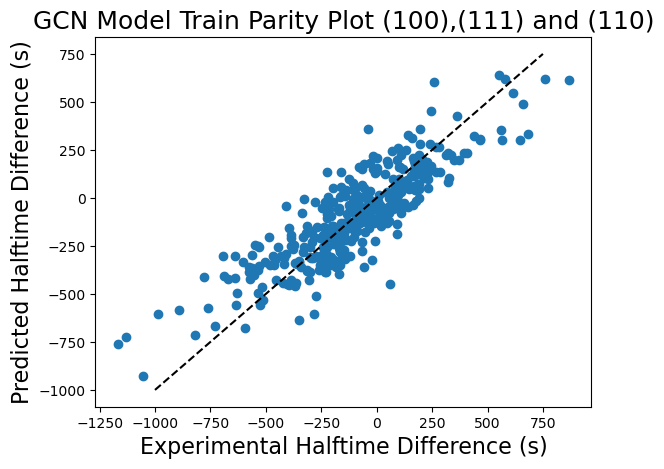

In [21]:
plt.plot(new_halftime_diff, new_halftime_diff_pred.reshape(-1,1) + intercept , 'o')
y_line = np.linspace(-1000, 750)
plt.plot(y_line, y_line, 'k--')
r2 = r2_score(new_halftime_diff, new_halftime_diff_pred.reshape(-1,1) + intercept)
mae = mean_absolute_error(new_halftime_diff,new_halftime_diff_pred.reshape(-1,1) + intercept)
print(f'r2 score: {r2:0.2f}, MAE score: {mae:0.2f}')
plt.title("GCN Model Train Parity Plot (100),(111) and (110)",fontsize = 18)
plt.xlabel("Experimental Halftime Difference (s)",fontsize = 16)
plt.ylabel("Predicted Halftime Difference (s)",fontsize = 16);

In [22]:
# calculate the halftime difference (L-TA - D-TA) on S surfaces and (D-TA - L-TA) on R
halftime_diff = y_lsdr_test.values - y_lrds_test.values

# calculate the halftime difference predictions
halftime_diff_pred = model_lsdr.predict(X_lsdr_test.values) - model_lrds.predict(X_lrds_test.values)

In [23]:
# multiply the halftime difference values on S surfaces by -1 to get (D-TA - L-TA) on S 
new_halftime_diff = halftime_diff.copy()
new_halftime_diff[test_s_idx] = -1 * halftime_diff[test_s_idx] 

# multiply the halftime difference predictions on S surfaces by -1 to get (D-TA - L-TA) on S 
new_halftime_diff_pred = halftime_diff_pred.copy()
new_halftime_diff_pred[test_s_idx] = -1 * halftime_diff_pred[test_s_idx] 

r2 score: 0.73, MAE score: 122.83


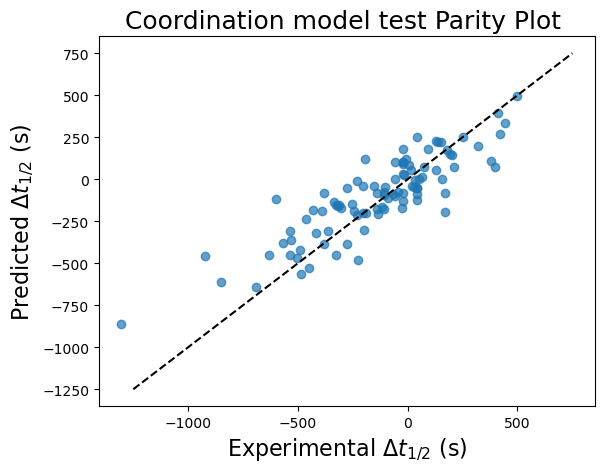

In [24]:
plt.plot(new_halftime_diff, new_halftime_diff_pred.reshape(-1,1) + intercept, 'o',alpha = 0.7)
y_line = np.linspace(-1250, 750)
plt.plot(y_line, y_line, 'k--')
r2 = r2_score(new_halftime_diff, new_halftime_diff_pred.reshape(-1,1) + intercept)
mae = mean_absolute_error(new_halftime_diff, new_halftime_diff_pred.reshape(-1,1) + intercept)
print(f'r2 score: {r2:0.2f}, MAE score: {mae:0.2f}')

plt.title("Coordination model test Parity Plot ",fontsize = 18)
plt.xlabel("Experimental $\Delta t_{1/2}$ (s)",fontsize = 16)
plt.ylabel("Predicted $\Delta t_{1/2}$ (s)",fontsize = 16)
# plt.gca().set_aspect('equal')
# plt.gcf().set_size_inches(10, 8)
plt.show()

In [25]:
## remove the xy stereographic projections to get the gcn features only
X_lsdr.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)
X_lrds.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)

#### It is simpler to get the halftime difference when you are training on the whole lsdr and lrds datasets without splitting to train and test. You can simply place the lsdr predictions in a lsdr dataframe and the lrds predictions in a lrds. Then, you can merge these two dataframes to get the original dataset with the correct ordering. Then, if you divide this dataset into D-TA dataframe and L-TA dataframe, you can get the halftime difference easily. 

In [26]:
def predictions_df(sample_df, model, X_train):
    ''' This function returns the combines predictions into a dataframe '''
    df_train = pd.DataFrame({"half_time" : model.predict(X_train).reshape(-1,)})
    return df_train

In [27]:
def combined_pred(lsdr_df, model_lsdr, X_lsdr_train, lrds_df, model_lrds, X_lrds_train):
    # Create dataframe of training labels and test labels predictions with the right indices 
    # and join to original dataframe for the lsdr model. 
    lsdr_pred  = predictions_df(lsdr_df, model_lsdr, X_lsdr_train,)
    lsdr_pred.set_index(lsdr_df.index, inplace=True)
    lsdr_df = lsdr_df.join(lsdr_pred["half_time"])
    lsdr_df.rename(columns={"half_time": "half_time_pred"}, inplace=True)
    # do the same thing for the lrds model
    lrds_pred  = predictions_df(lrds_df, model_lrds, X_lrds_train,)
    lrds_pred.set_index(lrds_df.index, inplace=True)
    lrds_df = lrds_df.join(lrds_pred["half_time"])
    lrds_df.rename(columns={"half_time": "half_time_pred"}, inplace=True)
    # Combine the two dataframes to get all the data back together
    pred_df = pd.merge(lsdr_df, lrds_df, "outer")
    # divide the dataframes into two dataframes, one for D-TA and one for L-TA
    lta_df = pred_df[pred_df['molecule'] == "L-TA"]
    lta_df  = lta_df.reset_index(drop=True)
    dta_df = pred_df[pred_df['molecule'] == "D-TA"]
    return lta_df, dta_df

In [28]:
lta_df, dta_df = combined_pred(df.loc[filt_lsdr], model_lsdr, X_lsdr, df.loc[filt_lrds], model_lrds, X_lrds)

In [29]:
# Get the halftime difference predictions for the (100) sample
df_100 = df[df["normal_miller_index"]== 100]
# get the dta halftimes for the (100) sample points
pred_100_dta = df_100[df_100["molecule"]=="D-TA"].merge(dta_df[dta_df["normal_miller_index"]== 100], on=["stereographic_projection_x", "stereographic_projection_y"])
# get the lta halftimes for the (100) sample points
pred_100_lta = df_100[df_100["molecule"]=="L-TA"].merge(lta_df[lta_df["normal_miller_index"]== 100], on=["stereographic_projection_x", "stereographic_projection_y"])
# calculate the halftime difference
delta_t_100 = pred_100_dta["half_time_pred"].values - pred_100_lta["half_time_pred"].values
# get the stereographic projections for plotting later
xy_100_p = df_100[df_100["molecule"]=="D-TA"][["stereographic_projection_x", "stereographic_projection_y"]].values

In [30]:
# Get the halftime difference predictions for the (111) sample
df_111 = df[df["normal_miller_index"]== 111]
# get the dta halftimes for the (111) sample points
pred_111_dta = df_111[df_111["molecule"]=="D-TA"].merge(dta_df[dta_df["normal_miller_index"]== 111], on=["stereographic_projection_x", "stereographic_projection_y"])
# get the lta halftimes for the (111) sample points
pred_111_lta = df_111[df_111["molecule"]=="L-TA"].merge(lta_df[lta_df["normal_miller_index"]== 111], on=["stereographic_projection_x", "stereographic_projection_y"])
# calculate the halftime difference
delta_t_111 = pred_111_dta["half_time_pred"].values - pred_111_lta["half_time_pred"].values
# get the stereographic projections for plotting 
xy_111_p = df_111[df_111["molecule"]=="D-TA"][["stereographic_projection_x", "stereographic_projection_y"]].values

In [31]:
# Get the halftime difference predictions for the (110) sample
df_110 = df[df["normal_miller_index"]== 110]
# get the dta halftimes for the (110) sample points
pred_110_dta = df_110[df_110["molecule"]=="D-TA"].merge(dta_df[dta_df["normal_miller_index"]== 110], on=["stereographic_projection_x", "stereographic_projection_y"])
# get the lta halftimes for the (110) sample points
pred_110_lta = df_110[df_110["molecule"]=="L-TA"].merge(lta_df[lta_df["normal_miller_index"]== 110], on=["stereographic_projection_x", "stereographic_projection_y"])
# calculate the halftime difference
delta_t_110 = pred_110_dta["half_time_pred"].values - pred_110_lta["half_time_pred"].values

### An issue that was found during plotting is that the (110) sample had a discontinuity in its contour plot. This was caused because this sample has high density of achiral surfaces. When these achiral surfaces are removed, the contour plot looks discontinuous. Therefore, the achiral points of the (110) sample are added back to the sample with a prediction of zero.

In [32]:
# create this data frame for the (110) sample with the achiral surfaces for plotting 
df_110_with_achiral = df_full[df_full["normal_miller_index"]== 110]
df_110_dta_achiral = df_110_with_achiral[df_110_with_achiral["molecule"]=="D-TA"]
# get the stereographic projections for plotting later
xy_110_p = df_110_dta_achiral[["stereographic_projection_x", "stereographic_projection_y"]].values

# include the achiral surfaces in the (110) sample to remove the discontinuous part of this sample
new_halftime_diff_110 = np.zeros((169,))
new_halftime_diff_110[np.where(df_110_dta_achiral["surface_chirality"]!="A")[0]] = delta_t_110

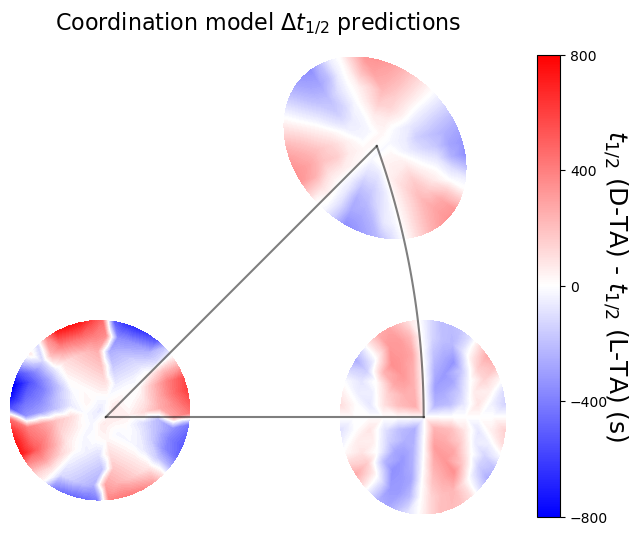

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
norm = plt.Normalize(vmin=-800, vmax=800)
ax.tricontourf(xy_100_p[:,0], xy_100_p[:,1],delta_t_100.reshape(-1,),levels = 100,cmap='bwr', norm = norm)
ax.tricontourf(xy_110_p[:,0], xy_110_p[:,1] ,new_halftime_diff_110.reshape(-1,),levels = 100,cmap='bwr', norm = norm)
ax.tricontourf(xy_111_p[:,0], xy_111_p[:,1],delta_t_111.reshape(-1,),levels = 100,cmap='bwr', norm = norm)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax = ax,orientation="vertical")
cbar.set_ticks(np.linspace(-800, 800, 5))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("$t_{1/2}$ (D-TA) - $t_{1/2}$ (L-TA) (s)", fontsize= 18,rotation=270)
#Draw the stereograhic triangle
x_values_1 = 0, 0.76235
y_values_1 =  0, 0
plt.plot(x_values_1, y_values_1, 'k', linestyle="-", alpha = 0.5)
x_values_2 = 0, 0.65
y_values_2 =  0, 0.65
plt.plot(x_values_2, y_values_2, 'k', linestyle="-", alpha = 0.5)
point1 = [0.65,  0.65]
point2 = [0, 0.76235]
y_1,x_1 = hanging_line(point1, point2)
plt.plot(x_1,y_1,'k', linestyle="-", alpha = 0.5)
ax.set_title("Coordination model $\Delta t_{1/2}$ predictions", fontsize = 16, pad=20)
ax.axis('off')
plt.gca().set_aspect('equal')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

### Extrapolate to the rest of the stereographic triangle

In [34]:
full_triangle_predictions = pd.read_csv("full_triangle_gcn_features.csv")
full_triangle_predictions_2 =  full_triangle_predictions.query("surface_chirality!='A'")
# get the miller indices, stereographic projections and halftime difference predictions
full_triangle_predictions_2.drop_duplicates(["stereo_x", "stereo_y"], inplace = True)
final_miller_idx = full_triangle_predictions_2[["h", "k", "l"]].values
new_xy_p = full_triangle_predictions_2[["stereo_x", "stereo_y"]].values

In [35]:
full_triangle_predictions

,miller_indices,h,k,l,stereo_x,stereo_y,GCN Density 4.75,GCN Density 4.833,GCN Density 4.917,GCN Density 5.0,GCN Density 5.083,GCN Density 5.167,GCN Density 5.417,GCN Density 5.5,GCN Density 5.583,GCN Density 5.667,GCN Density 5.75,GCN Density 5.833,GCN Density 5.917,GCN Density 6.0,GCN Density 6.167,GCN Density 6.25,GCN Density 6.333,GCN Density 6.417,GCN Density 6.5,GCN Density 6.583,GCN Density 6.667,GCN Density 6.75,GCN Density 6.833,GCN Density 6.917,GCN Density 7.0,GCN Density 7.083,GCN Density 7.167,GCN Density 7.25,GCN Density 7.333,GCN Density 7.417,GCN Density 7.5,GCN Density 7.583,GCN Density 7.667,GCN Density 7.75,GCN Density 7.833,GCN Density 7.917,GCN Density 8.0,GCN Density 8.083,GCN Density 8.167,GCN Density 8.25,GCN Density 8.333,GCN Density 8.417,GCN Density 8.5,GCN Density 8.583,GCN Density 8.667,GCN Density 8.75,GCN Density 8.833,GCN Density 8.917,GCN Density 9.0,GCN Density 9.083,GCN Density 9.167,GCN Density 9.25,GCN Density 9.333,GCN Density 9.417,GCN Density 9.5,GCN Density 9.583,GCN Density 9.667,GCN Density 9.75,surface_chirality
0,[1 0 0],1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,A
1,[1 1 0],0.707107,0.707107,0.000000,0.414214,0.000000,0.000000e+00,0.0,9.361724e-17,0.0,0.000000,0.000000e+00,0.0,-7.401487e-18,0.0,0.0,9.361724e-17,5.000000e-01,0.0,9.361724e-17,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,9.361724e-17,0.0,-7.401487e-18,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,9.361724e-17,0.0,0.0,0.0,5.000000e-01,0.000000,0.0,0.000000e+00,-7.401487e-18,9.361724e-17,0.0,0.0,A
2,[2 0 0],1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,A
3,[2 1 0],0.894427,0.447214,0.000000,0.236068,0.000000,5.782412e-19,0.0,-8.945391e-17,0.0,0.333333,5.782412e-19,0.0,0.000000e+00,0.0,0.0,0.000000e+00,5.782412e-19,0.0,0.000000e+00,0.0,0.0,0.0,-9.003215e-17,5.782412e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.782412e-19,0.333333,5.782412e-19,0.0,0.000000e+00,0.0,-9.003215e-17,0.0,0.000000e+00,0.0,0.0,5.782412e-19,0.0,0.0,0.0,5.782412e-19,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,-8.945391e-17,0.333333,0.0,5.782412e-19,0.000000e+00,5.782412e-19,0.0,0.0,A
4,[2 2 0],0.707107,0.707107,0.000000,0.414214,0.000000,0.000000e+00,0.0,-9.546575e-17,0.0,0.000000,0.000000e+00,0.0,4.857226e-18,0.0,0.0,-9.546575e-17,5.000000e-01,0.0,-9.546575e-17,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,-9.546575e-17,0.0,4.857226e-18,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,-9.546575e-17,0.0,0.0,0.0,5.000000e-01,0.000000,0.0,0.000000e+00,4.857226e-18,-9.546575e-17,0.0,0.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,[20 20 18],0.596550,0.596550,0.536895,0.373649,0.336284,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,4.974973e-02,0.0,0.0

In [36]:
df_1 = full_triangle_predictions_2.copy()
df_1["molecule"] = "D-TA"
df_2 = full_triangle_predictions_2.copy()
df_2["molecule"] = "L-TA"
df = pd.concat([df_1, df_2])

In [37]:
#Filter data into two groups
#Group 1 - L-TA on S Surface or D-TA on R Surface
filt_l_on_s = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "S")
filt_d_on_r = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "R")
filt_lsdr = np.logical_or(filt_l_on_s, filt_d_on_r)
#Group 2 - L-TA on R Surface or D-TA on S Surface

filt_l_on_r = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "R")
filt_d_on_s = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "S")
filt_lrds = np.logical_or(filt_l_on_r, filt_d_on_s)

In [38]:
#Extract Features 
X_lsdr = df.loc[filt_lsdr, 'GCN Density 4.75' : 'GCN Density 9.75']
X_lrds = df.loc[filt_lrds, 'GCN Density 4.75' : 'GCN Density 9.75']

In [39]:
lta_df, dta_df = combined_pred(df.loc[filt_lsdr], model_lsdr, X_lsdr.values, df.loc[filt_lrds], model_lrds, X_lrds.values)

In [40]:
new_labels = dta_df["half_time_pred"].values - lta_df["half_time_pred"].values

In [41]:
full_triangle_predictions_2["half_time_pred"] = new_labels

In [42]:
new_new_xy_p = np.concatenate((new_xy_p, full_triangle_predictions.query("surface_chirality=='A'")[["stereo_x", "stereo_y"]].values), axis=0)

In [43]:
new_new_labels = np.concatenate((new_labels,np.zeros((len(full_triangle_predictions.query("surface_chirality=='A'"))))), axis=0)

In [44]:
print("Max differnce", np.max(new_labels), ", Min difference", np.min(new_labels))

Max differnce 1475.648837642268 , Min difference -991.3183497564402


In [45]:
# the surface with the highest absolute value of the halftime difference
print("maximum surface: ", np.round_(final_miller_idx[np.where(new_labels == np.max(np.abs(new_labels)))]/0.08737041))

maximum surface:  [[11.  3.  1.]]


In [46]:
new_xy_p[:,0][np.where(new_labels == np.max(new_labels))[0]], new_xy_p[:,1][np.where(new_labels == np.max(new_labels))[0]]

(array([0.13365694]), array([0.04455231]))

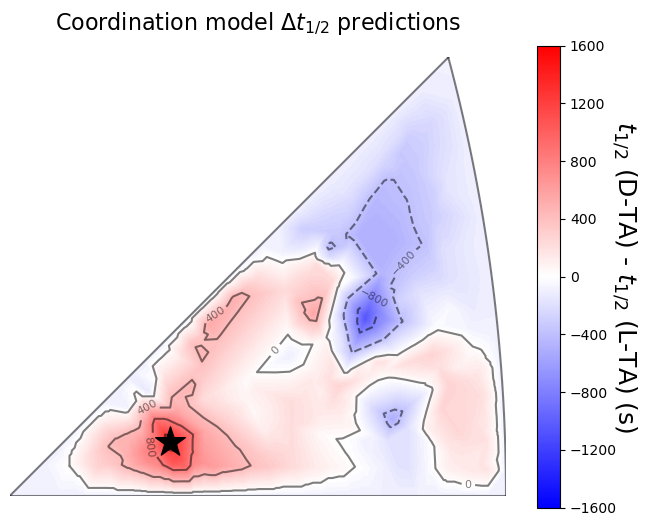

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
norm = matplotlib.colors.Normalize(vmin=-1600, vmax=1600)
ax.tricontourf(new_new_xy_p[:,0], new_new_xy_p[:,1],new_new_labels + intercept,levels = 100,cmap='bwr', norm = norm)
# Add contour lines at constant values
contour_lines = plt.tricontour(new_new_xy_p[:,0], new_new_xy_p[:,1],new_new_labels + intercept, levels=np.linspace(-1600, 1600, 9), 
colors='k', alpha=0.5,)

# Add labels to contour lines
plt.clabel(contour_lines, inline=True, fontsize=8)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax = ax,orientation="vertical")
cbar.set_ticks(np.linspace(-1600, 1600, 9))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("$t_{1/2}$ (D-TA) - $t_{1/2}$ (L-TA) (s)", fontsize= 18,rotation=270)
#Draw the stereograhic triangle
x_values_1 = 0, 0.414214	
y_values_1 =  0, 0
ax.plot(x_values_1, y_values_1, 'k', linestyle="-", alpha = 0.5)
x_values_2 = 0, 0.366025	
y_values_2 =  0, 0.366025	
ax.plot(x_values_2, y_values_2, 'k', linestyle="-", alpha = 0.5)
point1 = [0.366025	, 0.366025]
point2 = [0, 0.414214	]
y_1,x_1 = hanging_line(point1, point2)
ax.plot(x_1,y_1,'k', linestyle="-", alpha = 0.5)

# highlight the GCN optimal surface 
ax.scatter(new_new_xy_p[:,0][np.where(new_new_labels == np.max(new_new_labels))[0]], 
        new_new_xy_p[:,1][np.where(new_new_labels == np.max(new_new_labels))[0]], c = 'k',  s=500,  edgecolors='black', marker="*") #label = f"{max_miller}",

ax.set_title("Coordination model $\Delta t_{1/2}$ predictions", fontsize = 16, pad=20)
ax.axis('off')
plt.gca().set_aspect('equal')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

## Uncertainty in the data
### train 1000 models on different data splits and use their statistics to get uncertainity in the optimal value and the optimal location. 

In [48]:
optimal_locations = []
optimal_value = []
coef = []
all_labels = []
for i in np.random.randint(50000000, size=1000):
    df = df_full[df_full["surface_chirality"]!="A"]
    #Filter data into two groups
    #Group 1 - L-TA on S Surface or D-TA on R Surface
    filt_l_on_s = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "S")
    filt_d_on_r = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "R")
    filt_lsdr = np.logical_or(filt_l_on_s, filt_d_on_r)
    #Group 2 - L-TA on R Surface or D-TA on S Surface
    filt_l_on_r = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "R")
    filt_d_on_s = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "S")
    filt_lrds = np.logical_or(filt_l_on_r, filt_d_on_s)
    #Extract Features 
    X_lsdr = df.loc[filt_lsdr, 'stereographic_projection_x' : 'GCN Density 9.75']
    X_lrds = df.loc[filt_lrds, 'stereographic_projection_x' : 'GCN Density 9.75']
    #Extract Labels
    y_lsdr = df.loc[filt_lsdr, 'halftime(s)': "stereographic_projection_y"]
    y_lrds = df.loc[filt_lrds, 'halftime(s)': "stereographic_projection_y"]
    chiral_lsdr = df.loc[filt_lsdr, 'surface_chirality']
    #Split Data
    X_lsdr_train, X_lsdr_test, y_lsdr_train, y_lsdr_test, idx_train, idx_test = train_test_split(X_lsdr, y_lsdr, chiral_lsdr, test_size=0.2, random_state=i)
    
    train_s_idx = np.where(idx_train == "S")
    test_s_idx = np.where(idx_test == "S")

    # first you merge on lsdr train split based on stereo_x and stereo_y
    X_lrds_train = pd.merge(X_lsdr_train, X_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
    # second you get rid of the lsdr features and the stereo_x and stereo_y columns which are the first 60 columns
    X_lrds_train = X_lrds_train.iloc[:,60:]
    # same procedure is done for the test features
    X_lrds_test  = pd.merge(X_lsdr_test, X_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
    X_lrds_test = X_lrds_test.iloc[:,60:]

    # same idea for the lrds train labels
    y_lrds_train = pd.merge(y_lsdr_train, y_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
    # here you remove the last two columns which are the stereo_x and stereo_y and the halftime for the lsrd dataset columns
    y_lrds_train = y_lrds_train.iloc[:,3:]
    # same idea for the lrds test labels
    y_lrds_test = pd.merge(y_lsdr_test, y_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
    y_lrds_test = y_lrds_test.iloc[:,3:]
    
    # remove the stereo_x and stereo_y columns from the lsdr and lrds train and test features
    X_lsdr_train.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)
    X_lsdr_test.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)

    y_lsdr_train.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)
    y_lsdr_test.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)   
    

    model_lsdr_new  = Ridge(alpha=0.01)
    model_lrds_new = Ridge(alpha=0.01) 
    
    #Fit models
    model_lsdr_new.fit(X_lsdr_train.values, y_lsdr_train )
    model_lrds_new.fit(X_lrds_train.values, y_lrds_train)
    
    # get the coeffcient value of the 6.416
    coef.append(model_lsdr_new.coef_[0][-4])
    
    df = pd.concat([df_1, df_2])
    #Filter data into two groups
    #Group 1 - L-TA on S Surface or D-TA on R Surface
    filt_l_on_s = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "S")
    filt_d_on_r = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "R")
    filt_lsdr = np.logical_or(filt_l_on_s, filt_d_on_r)
    #Group 2 - L-TA on R Surface or D-TA on S Surface

    filt_l_on_r = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "R")
    filt_d_on_s = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "S")
    filt_lrds = np.logical_or(filt_l_on_r, filt_d_on_s)
    
    #Extract Features 
    X_lsdr = df.loc[filt_lsdr, 'GCN Density 4.75' : 'GCN Density 9.75']
    X_lrds = df.loc[filt_lrds, 'GCN Density 4.75' : 'GCN Density 9.75']
    
    lta_df, dta_df = combined_pred(df.loc[filt_lsdr], model_lsdr_new, X_lsdr.values, df.loc[filt_lrds], model_lrds_new, X_lrds.values)
    new_labels = dta_df["half_time_pred"].values - lta_df["half_time_pred"].values
    
    optimal_locations.append(new_xy_p[np.where(new_labels == np.max(new_labels))[0][0]])
    optimal_value.append(np.max(new_labels))
    all_labels.append(new_labels)

optimal_locations = np.array(optimal_locations)
optimal_value = np.array(optimal_value)
coef = np.array(coef)
all_labels = np.array(all_labels)

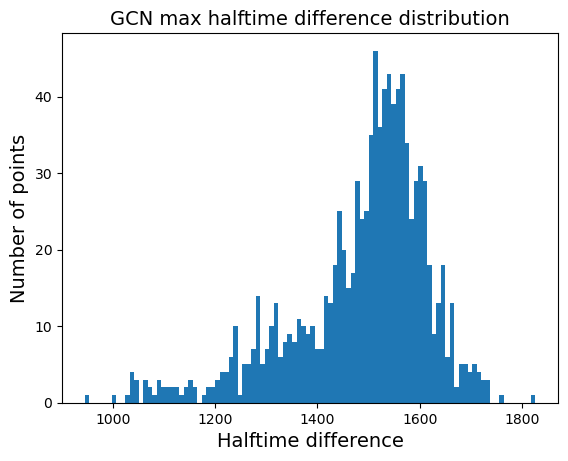

In [49]:
plt.hist(optimal_value-100, density=False, bins=100)  
plt.xlabel("Halftime difference", fontsize = 14)
plt.ylabel("Number of points", fontsize = 14)
plt.title("GCN max halftime difference distribution", fontsize = 14)
plt.show()

In [50]:
count = []
unique_opts = []
mean_opt_value = []
std_opt_value = []
for j in np.unique(optimal_locations[:,0]):
    count.append(len(np.where(optimal_locations[:,0] == j)[0]))
    unique_opts.append(optimal_locations[np.where(optimal_locations[:,0] == j)[0][0]])
    mean_opt_value.append(np.mean(optimal_value[np.where(optimal_locations[:,0] == j)[0]]))
    std_opt_value.append(np.std(optimal_value[np.where(optimal_locations[:,0] == j)[0]]))
unique_opts = np.array(unique_opts)

In [51]:
np.mean(np.max(all_labels, axis =1)-100), np.std(np.max(all_labels, axis =1)-100)

(1486.478454868754, 134.3603115862336)

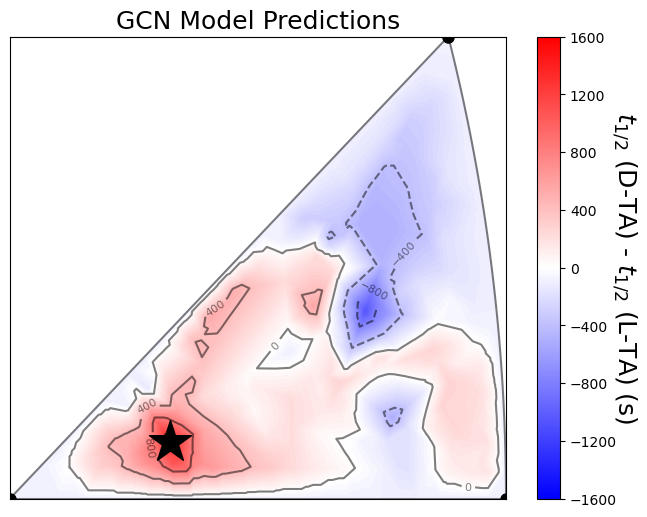

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))
norm = matplotlib.colors.Normalize(vmin=-1600, vmax=1600)
ax.tricontourf(new_new_xy_p[:,0], new_new_xy_p[:,1],new_new_labels + intercept,levels = 100,cmap='bwr', norm = norm)
# Add contour lines at constant values
contour_lines = plt.tricontour(new_new_xy_p[:,0], new_new_xy_p[:,1],new_new_labels + intercept, levels=np.linspace(-1600, 1600, 9), 
colors='k', alpha=0.5,)

# Add labels to contour lines
plt.clabel(contour_lines, inline=True, fontsize=8)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax = ax,orientation="vertical")
cbar.set_ticks(np.linspace(-1600, 1600, 9))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("$t_{1/2}$ (D-TA) - $t_{1/2}$ (L-TA) (s)", fontsize= 18,rotation=270)

ax.scatter(unique_opts[:,0], unique_opts[:,1], c = "k", marker="*", s = np.array(count),)

plt.plot(0, 0, 'k', marker="o", markersize=8, label = "(100)")
plt.plot(0.414214, 0, 'k', marker="o", markersize=8, label = "(110)")
plt.plot(0.366025, 0.366025, 'k', marker="o", markersize=8, label = "(111)")

#Draw the stereograhic triangle
x_values_1 = 0, 0.414214	
y_values_1 =  0, 0
ax.plot(x_values_1, y_values_1, 'k', linestyle="-", alpha = 0.5)
x_values_2 = 0, 0.366025	
y_values_2 =  0, 0.366025	
ax.plot(x_values_2, y_values_2, 'k', linestyle="-", alpha = 0.5)
point1 = [0.366025, 0.366025]
point2 = [0, 0.414214	]
y_1,x_1 = hanging_line(point1, point2)
ax.plot(x_1,y_1,'k', linestyle="-", alpha = 0.5)
ax.set_title("GCN Model Predictions", fontsize = 18)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

### Trends

In [55]:
important_feat = full_triangle_predictions_2[['GCN Density 4.75', "GCN Density 9.333", 'GCN Density 6.417', "GCN Density 5.583",]].values
important_feat_sum = full_triangle_predictions_2[['GCN Density 4.75', "GCN Density 9.333", 'GCN Density 6.417', "GCN Density 5.583", ]].values.sum(axis = 1) 

In [56]:
# Effect of increasing the terrace width
higher_terrace_width = ['[11  3  1]','[12  3  1]', '[13  3  1]','[14  3  1]','[15  3  1]','[16  3  1]','[17  3  1]','[18  3  1]','[19  3  1]','[20  3  1]']
higher_terrace_width_df = full_triangle_predictions_2.query(f"miller_indices=={higher_terrace_width}")
higher_terrace_width_df[['GCN Density 4.75', "GCN Density 9.333", 'GCN Density 6.417', "GCN Density 5.583", ]].values.sum(axis = 1) 

array([0.57142857, 0.46666667, 0.35662431, 0.26168369, 0.17896749,
       0.10627885, 0.10083531, 0.0953278 , 0.09038046, 0.08591831])

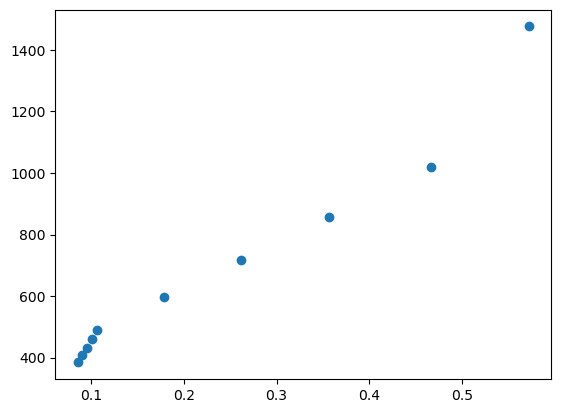

In [57]:
plt.plot(higher_terrace_width_df[['GCN Density 4.75', "GCN Density 9.333", 'GCN Density 6.417', "GCN Density 5.583", ]].values.sum(axis = 1) ,
         higher_terrace_width_df["half_time_pred"], "o")

In [52]:
# add (111) to increase step width
higher_step_width = ['[11  3  1]','[12  4  2]', '[13  5  3]','[14  6  4]','[15  7  5]','[16  8  6]','[17  9  7]','[18  10  8]','[19  11  9]','[20  12  10]']
higher_step_width_df = full_triangle_predictions_2.query(f"miller_indices=={higher_step_width}")
higher_step_width_df[['GCN Density 4.75', "GCN Density 9.333", 'GCN Density 6.417', "GCN Density 5.583", ]].values.sum(axis = 1) 

array([0.57142857, 0.11089541, 0.181485  , 0.19230745])

In [53]:
# add (110) to increase step width?
higher_step_width = ['[11  3  1]','[12  4  1]', '[13  5  1]','[14  6  1]','[15  7  1]','[16  8  1]','[17  9  1]','[18  10  1]','[19  11  1]','[20  12  1]']
higher_step_width_df = full_triangle_predictions_2.query(f"miller_indices=={higher_step_width}")
higher_step_width_df[['GCN Density 4.75', "GCN Density 9.333", 'GCN Density 6.417', "GCN Density 5.583", ]].values.sum(axis = 1) 

array([0.57142857, 0.31226688, 0.15562307, 0.05      , 0.05200618,
       0.04167716, 0.03854849])

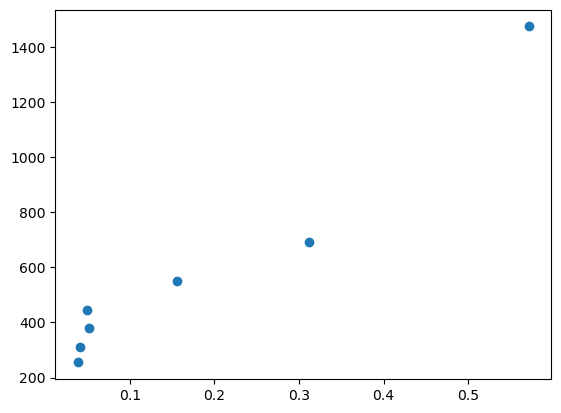

In [54]:
plt.plot(higher_step_width_df[['GCN Density 4.75', "GCN Density 9.333", 'GCN Density 6.417', "GCN Density 5.583", ]].values.sum(axis = 1) ,
         higher_step_width_df["half_time_pred"], "o")

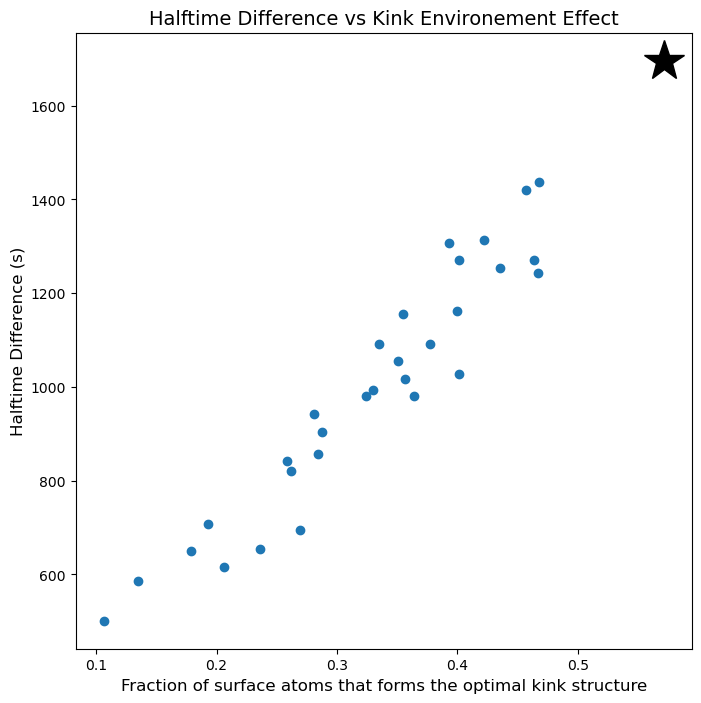

In [87]:
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.plot(important_feat_sum[np.where(np.product(important_feat, axis = 1)!=0)], new_labels[np.where(np.product(important_feat, axis = 1)!=0)], "o", alpha = 1)
ax.plot(important_feat_sum[np.where(new_labels == np.max(np.abs(new_labels)))[0]], np.abs(new_labels)[np.where(new_labels == np.max(np.abs(new_labels)))[0]],"k*",markersize=30)
ax.set_title("Halftime Difference vs Kink Environement Effect",fontsize = 14)
ax.set_xlabel("Fraction of surface atoms that forms the optimal kink structure",fontsize = 12)
ax.set_ylabel("Halftime Difference (s)",fontsize = 12)
plt.gca().set_aspect('equal')
ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
# ax.set_xticks(fontsize = 14)
# ax.set_yticks(fontsize = 14);